In [54]:
import copy

import pandas as pd
import numpy as np
import os

In [55]:
# 添加验证集和测试集
train_df = pd.read_csv('../UJIIndoorLoc/trainingData.csv')
train_df_noisy = pd.read_csv('../data/train_noisy.csv')
train_df_noisy1 = pd.read_csv('../data/train_noisy1.csv')
train_df_noisy2 = pd.read_csv('../data/train_noisy2.csv')
# train_df_noisy3 = pd.read_csv('../data/train_noisy3.csv')
train_df_noisy4 = pd.read_csv('../data/train_noisy4.csv')
train_df_noisy5 = pd.read_csv('../data/train_noisy5.csv')

# train_df = pd.concat([train_df, train_df_noisy4], ignore_index=True)
train_df = pd.concat([train_df, train_df_noisy1], ignore_index=True)
# train_df = pd.concat([train_df, train_df_noisy2], ignore_index=True)
# train_df = pd.concat([train_df, train_df_noisy5], ignore_index=True)
valid_df = pd.read_csv('../UJIIndoorLoc/validationData.csv')

total_df = pd.concat([train_df, valid_df])

In [56]:
# 训练集特征
training_data = train_df[train_df.columns[:520]].to_numpy()
# training_data[training_data == 100] = -110
training_floors = train_df['FLOOR'].to_numpy() # FLOOR LABELS
training_buildings = train_df['BUILDINGID'].to_numpy() # BUILDING LABELS
training_longitude = train_df['LONGITUDE'].to_numpy() # LONGITUDE LABELS
training_latitude = train_df['LATITUDE'].to_numpy() # LATITUDE LABELS
training_coords = train_df[['LONGITUDE','LATITUDE']].to_numpy() # LONGITUDE + LATITUDE LABELS
print(training_coords[0])

[  -7541.2643 4864920.7782]


In [57]:
# 验证机特征
valid_data = valid_df[valid_df.columns[:520]].to_numpy()
# valid_data[valid_data == 100] = -110
valid_floors = valid_df['FLOOR'].to_numpy() # FLOOR LABELS
valid_buildings = valid_df['BUILDINGID'].to_numpy() # BUILDING LABELS
valid_longitude = valid_df['LONGITUDE'].to_numpy() # LONGITUDE LABELS
valid_latitude = valid_df['LATITUDE'].to_numpy() # LATITUDE LABELS
valid_coords = valid_df[['LONGITUDE','LATITUDE']].to_numpy() # LONGITUDE + LATITUDE LABELS

In [58]:
totaling_data = total_df[total_df.columns[:520]].to_numpy()
# totaling_data[totaling_data == 100] = -110
totaling_floors = total_df['FLOOR'].to_numpy() # FLOOR LABELS
totaling_buildings = total_df['BUILDINGID'].to_numpy() # BUILDING LABELS
totaling_longitude = total_df['LONGITUDE'].to_numpy() # LONGITUDE LABELS
totaling_latitude = total_df['LATITUDE'].to_numpy() # LATITUDE LABELS
totaling_coords = total_df[['LONGITUDE','LATITUDE']].to_numpy() # LONGITUDE + LATITUDE LABELS

In [59]:
# from sklearn.preprocessing import StandardScaler
# from Algorithms.utill.ELM import ELM_AE
# # 2. 标准化
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(training_data)
# 
# # 3. ELM降维
# elm_ae = ELM_AE(input_dim=training_data.shape[1], hidden_dim=256)
# training_data = elm_ae.fit_transform(X_scaled)
# 
# print(training_data[0])
# print(totaling_coords[0])

In [60]:
from utill.data_standar import normalize_rssi, normalize_coords, normalize_test_or_valid_data
# 数据标准化,从总数居获取最大值最小值
X_totalCo_cnn, X_min, X_max = normalize_rssi(totaling_data)
print(X_min, X_max)
# 训练集特征标准化
training_data = normalize_test_or_valid_data(X_min, X_max, training_data)
# 验证集特征标准化
valid_data = normalize_test_or_valid_data(X_min, X_max, valid_data)
# 训练集经度标签标准化
print(training_coords[0])
training_latitude, y_min_la, y_max_la = normalize_coords(totaling_latitude, training_latitude)
# 验证集经度标签标准化
valid_latitude, y_va_min_la, y_va_max_la = normalize_coords(totaling_latitude, valid_latitude)
# 训练集纬度标签标准化
print(training_coords[0])
training_longitude, y_min_lo, y_max_lo = normalize_coords(totaling_longitude, training_longitude)
# 验证集纬度标签标准化
valid_longitude, y_va_min, y_va_max = normalize_coords(totaling_longitude, valid_longitude)
# 保存的最大，最小值
print(y_min_la, y_max_la, y_min_lo, y_max_lo)
min_max_dist = [y_min_la, y_max_la, y_min_lo, y_max_lo]

-105.41166034560202 100.0
[  -7541.2643 4864920.7782]
[  -7541.2643 4864920.7782]
4864745.745015971 4865017.364684202 -7695.93875492993 -7299.786516730871


In [61]:
print(training_data.shape)

(39874, 520)


In [62]:
# Augmenting data shape to fit 23x23
training_data_aug = np.empty((len(training_data),529))
for x in range(len(training_data)):
    training_data_aug[x] = np.concatenate((training_data[x], np.full(shape=9,fill_value=1)))
# Augmenting data shape to fit 23*23
valid_data_aug = np.empty((len(valid_data),529))
for x in range(len(valid_data)):
    valid_data_aug[x] = np.concatenate((valid_data[x], np.full(shape=9,fill_value=1)))
# valid_data_aug.shape
# training_data_aug = training_data

In [63]:
from sklearn.model_selection import train_test_split

train_space_ids = train_df['SPACEID'].values
X_train_la_cnn, X_test_la_cnn, y_train_la_cnn, y_test_la_cnn = train_test_split(training_data_aug.reshape(len(training_data_aug),23,23), training_latitude, test_size=0.2, random_state=2812,stratify=train_space_ids)
# X_trainCo_cnn, y_trainCo_cnn = training_data_aug.reshape(len(training_data_aug),23,23), training_coords
X_valid_la_cnn, y_valid_la_cnn = valid_data_aug.reshape(len(valid_data_aug),23,23), valid_latitude


# valid_ids =  valid_df['SPACEID'].values
# 只取纬度作为训练
X_train_lo_cnn, X_test_lo_cnn, y_train_lo_cnn, y_test_lo_cnn = train_test_split(training_data_aug.reshape(len(training_data_aug),23,23), training_longitude, test_size=0.2, random_state=2812, stratify=train_space_ids)
# X_trainCo_cnn, y_trainCo_cnn = training_data_aug.reshape(len(training_data_aug),23,23), training_coords
X_valid_lo_cnn, y_valid_lo_cnn = valid_data_aug.reshape(len(valid_data_aug),23,23), valid_longitude

In [64]:
print(y_train_la_cnn[:5])
print(y_test_la_cnn[:5])
print(y_train_lo_cnn[:5])
print(y_test_lo_cnn[:5])

[0.90565895 0.74495856 0.93833663 0.29763918 0.34818938]
[0.05350294 0.14914304 0.50588378 0.25023918 0.44562341]
[0.14961636 0.40572594 0.14665992 0.63203197 0.85655645]
[0.83985521 0.75911613 0.66512474 0.95688354 0.33762918]


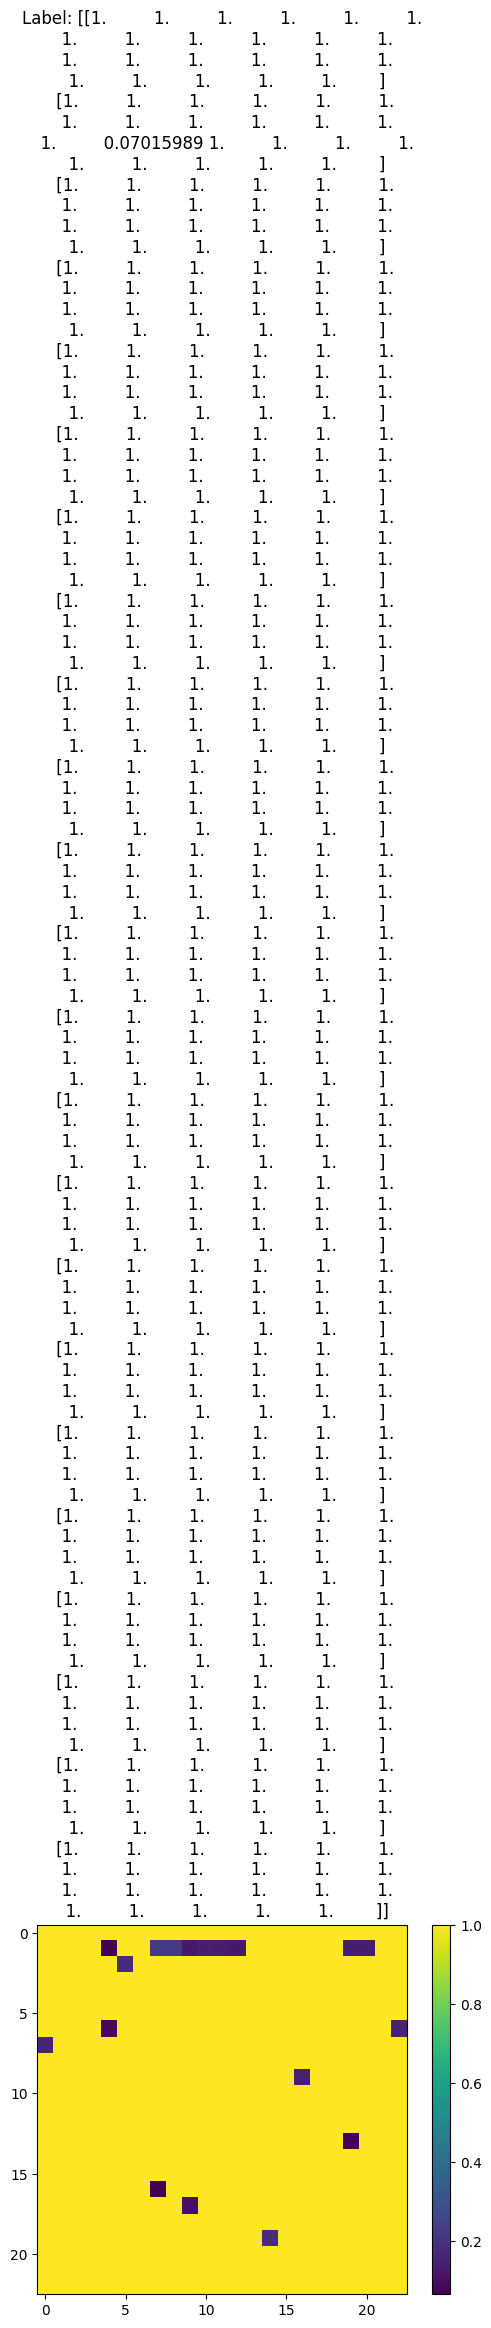

In [65]:
import matplotlib.pyplot as plt
single_image = X_train_la_cnn[0]
plt.imshow(single_image)
plt.title(f'Label: {X_valid_la_cnn[0]}')
plt.colorbar()
plt.show()

In [66]:
from CNN import CNNRegressor
from utill.data_standar import denormalize_coords, mean_euclidean_distance

In [67]:
# Longitude+Latitude Regressor
dropout = [0.2]
val_kernel = [7]
val_padding = [3]
for val in dropout:
    for i in range(1):
        print(f'(Dropout: {val}) (kernel: {val_kernel[i]}) (padding: {val_padding[i]}) (lr: 0.001) (batch_size=100)')
        cnn = CNNRegressor(n_targets=1, dropout=val, kernel_size=val_kernel[i], padding=val_padding[i]) # Longitude + Latitude are targets
        cnn.fit(X_train_lo_cnn, y_train_lo_cnn, X_test_lo_cnn, y_test_lo_cnn)
        # cnn.fit(X_trainCo_cnn, y_trainCo_cnn_scaled, X_testCo_cnn, y_testCo_cnn_scaled)
        # cnn.train(num_epochs=100,eval_train=True, min_max_dist=min_max_dist, lr=0.0001, batch_size=16)
        cnn.train_model(num_epochs=300,eval_train=True, min_max_dist=min_max_dist, lr=0.0001, batch_size=64, patience = 7, sava_model_name="best_model_lo")


(Dropout: 0.2) (kernel: 7) (padding: 3) (lr: 0.001) (batch_size=100)
Epoch [1/300], Step [499/499], Loss: 0.0118
32.180286237720196
47.28823993846869
→ Model improved. Saving...
------------------------------
Epoch [2/300], Step [499/499], Loss: 0.0062
8.772821747575033
12.978983871795462
→ Model improved. Saving...
------------------------------
Epoch [3/300], Step [499/499], Loss: 0.0041
6.991306521116459
10.294542460963093
→ Model improved. Saving...
------------------------------
Epoch [4/300], Step [499/499], Loss: 0.0036
6.3948269614362925
9.399444657446026
→ Model improved. Saving...
------------------------------
Epoch [5/300], Step [499/499], Loss: 0.0034
5.806759086574569
8.620379748317617
→ Model improved. Saving...
------------------------------
Epoch [6/300], Step [499/499], Loss: 0.0032
5.305893081977875
8.00201987829081
→ Model improved. Saving...
------------------------------
Epoch [7/300], Step [499/499], Loss: 0.0032
4.979569739628126
7.59437115079367
→ Model improve

In [68]:
# Longitude+Latitude Regressor
dropout = [0.2]
val_kernel = [7]
val_padding = [3]
for val in dropout:
    for i in range(1):
        print(f'(Dropout: {val}) (kernel: {val_kernel[i]}) (padding: {val_padding[i]}) (lr: 0.001) (batch_size=100)')
        cnn = CNNRegressor(n_targets=1, dropout=val, kernel_size=val_kernel[i], padding=val_padding[i]) # Longitude + Latitude are targets
        cnn.fit(X_train_la_cnn, y_train_la_cnn, X_test_la_cnn, y_test_la_cnn)
        # cnn.fit(X_trainCo_cnn, y_trainCo_cnn_scaled, X_testCo_cnn, y_testCo_cnn_scaled)
        # cnn.train(num_epochs=100,eval_train=True, min_max_dist=min_max_dist, lr=0.0001, batch_size=16)
        cnn.train_model(num_epochs=300,eval_train=True, min_max_dist=min_max_dist, lr=0.0001, batch_size=64, patience = 7, sava_model_name="best_model_la")

(Dropout: 0.2) (kernel: 7) (padding: 3) (lr: 0.001) (batch_size=100)
Epoch [1/300], Step [499/499], Loss: 0.0097
44.70547319014647
65.12144645517806
→ Model improved. Saving...
------------------------------
Epoch [2/300], Step [499/499], Loss: 0.0021
9.158653914112906
13.611325632188006
→ Model improved. Saving...
------------------------------
Epoch [3/300], Step [499/499], Loss: 0.0016
7.844592824036437
11.624641500436313
→ Model improved. Saving...
------------------------------
Epoch [4/300], Step [499/499], Loss: 0.0011
8.181010083852259
12.112852260925036
→ No improvement. Patience: 1/7
------------------------------
Epoch [5/300], Step [499/499], Loss: 0.0009
6.83277712564191
10.312310317751558
→ Model improved. Saving...
------------------------------
Epoch [6/300], Step [499/499], Loss: 0.0008
5.9204026154963625
9.11172646622121
→ Model improved. Saving...
------------------------------
Epoch [7/300], Step [499/499], Loss: 0.0008
5.481196950103845
8.539518066100003
→ Model im

In [76]:
from CNN import CNNRegressor
import numpy as np
# 假设你的模型是 CNNRegressor，有两个目标值
model = CNNRegressor(n_targets=1, kernel_size=7, stride=1, padding=3, dropout=0.2)
 
# 加载保存的权重
model.load_model('best_model_la.pth')
model.X_train = np.zeros_like(X_valid_la_cnn)  # 随便补一个假的训练集占位，不会用到
model.Y_train = np.zeros_like(y_valid_la_cnn)
# 注意：还需要加载相应的数据
model.X_test = X_valid_la_cnn
model.Y_test = y_valid_la_cnn
# model.X_train = None
# model.y_train = None
model.create_loaders(batch_size=64)


predictions, targets = model.test(model.loaders['test'])

# 若你是多目标回归任务（例如RSSI定位），建议继续后处理：
preds_denorm_la = denormalize_coords(predictions, min_max_dist[0], min_max_dist[1])
targets_denorm_la = denormalize_coords(targets, min_max_dist[0], min_max_dist[1])

average_dist = mean_euclidean_distance(preds_denorm_la, targets_denorm_la)
print(f"Test set average Euclidean distance: {average_dist:.2f} meters")


Test set average Euclidean distance: 9.85 meters


In [78]:
from CNN import CNNRegressor
import numpy as np
# 假设你的模型是 CNNRegressor，有两个目标值
model = CNNRegressor(n_targets=1, kernel_size=7, stride=1, padding=3, dropout=0.2)
 
# 加载保存的权重
model.load_model('best_model_lo')
model.X_train = np.zeros_like(X_valid_lo_cnn)  # 随便补一个假的训练集占位，不会用到
model.Y_train = np.zeros_like(y_valid_lo_cnn)
# 注意：还需要加载相应的数据
model.X_test = X_valid_lo_cnn
model.Y_test = y_valid_lo_cnn
# model.X_train = None
# model.y_train = None
model.create_loaders(batch_size=64)


predictions, targets = model.test(model.loaders['test'])

# 若你是多目标回归任务（例如RSSI定位），建议继续后处理：
preds_denorm_lo = denormalize_coords(predictions, min_max_dist[2], min_max_dist[3])
targets_denorm_lo = denormalize_coords(targets, min_max_dist[2], min_max_dist[3])

average_dist = mean_euclidean_distance(preds_denorm_lo, targets_denorm_lo)
print(f"Test set average Euclidean distance: {average_dist:.2f} meters")

Test set average Euclidean distance: 13.44 meters


In [75]:
preds_denorm = np.hstack([preds_denorm_la, preds_denorm_lo]) 
targets_denorm = np.hstack([targets_denorm_la, targets_denorm_lo])

average_dist = mean_euclidean_distance(preds_denorm, targets_denorm)
print(f"Test set average Euclidean distance: {average_dist:.2f} meters")

Test set average Euclidean distance: 11.90 meters
